In [1]:
name = "abbott-labs"

bgval=255
subsample=10000
erosion_radius=3
pc_cutoff=2.5 # 3 before seemed okay
name_low_pc_score=0.7
name_high_pc_score=0.6 # prev val 0.6 was pretty good
low_pc_score=0.85
high_pc_score=0.8
i_score=0.99
o_score=0.85
amp_score=0.6
top_tolerance=0.05 
region_cutoff_perc=0.001
mark_eps_frac=0.0001 # mark_eps = 15
mark_frac_cutoff=0.005 # this was 0.01
min_dist_corners=5
entropy_disk_size=20
grey_thresh=0.9
qmr_cutoff=0.9
pc_diff_limit=2.0

In [2]:
# DEFINING ONE SUPER EXTRACTION FUNCTION WITH THE TUNING PARAMETERS EXPLICITLY DEFINED

import os
import warnings
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image

from skimage import measure, io, color, feature, morphology
from skimage.transform import resize, rescale
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import convex_hull_image, disk
from skimage.filters.rank import entropy

from scipy.stats import mode
import scipy.misc

from sklearn.cluster import DBSCAN, KMeans

from collections import OrderedDict

try:
    os.chdir("/media/ryan/hdd/Dropbox/1_proj/logos/code/extract_features/")
except:
    os.chdir("/Users/ryan/Dropbox/1_proj/logos/code/extract_features/")

from segmentation_functions import *

try:
    os.chdir("/media/ryan/hdd/Dropbox/1_proj/logos/")
except:
    os.chdir("/Users/ryan/Dropbox/1_proj/logos/")

In [3]:
img = io.imread("data/new_sources/logos/" + name + ".png")
fontdf = pd.read_csv("data/labeled_fonts_amp_wide.csv")
fontmat = fontdf.iloc[:,0:625].values.astype('float')

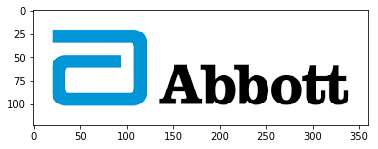

In [4]:
### Pre-process the logo:  ----------------------------------------------------------------------

img = standardize(img)
img = remove_white_bg(img)
img = add_padding(img, bgval=bgval)

plt.imshow(img)

(-0.5, 399.5, 162.5, -0.5)

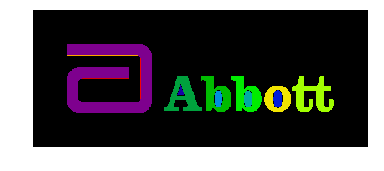

In [5]:
### Segment the image and isolate characters  ----------------------------------------------------------------------

# Segment the image by color regions:

quantized, centers, color_df = hsv_segmentation(img, name=name, subsample=subsample)
small_feats, feat_cols, areas, fracs, regionalized = extract_features(quantized, centers, region_cutoff_perc=region_cutoff_perc)


plt.imshow(regionalized, cmap="nipy_spectral")
plt.axis('off')

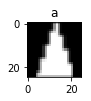

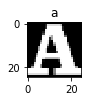

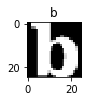

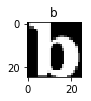

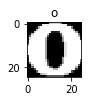

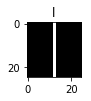

In [6]:
# Match features to fonts:

is_char, char_match, remaining_letters = detect_chars(small_feats, fontdf, name=name, 
                                                      pc_cutoff=pc_cutoff, 
                                                      name_low_pc_score=name_low_pc_score, 
                                                      name_high_pc_score=name_high_pc_score, 
                                                      low_pc_score=low_pc_score, high_pc_score=high_pc_score, 
                                                      i_score=i_score, 
                                                      o_score=o_score,
                                                      amp_score=amp_score,
                                                      top_tolerance=top_tolerance,
                                                     pc_diff_limit=pc_diff_limit)

letters_found = fontdf['letter'][char_match[is_char]].as_matrix()
if letters_found.size > 0:
    l = 0
    for s in range(small_feats.shape[2]):
        if is_char[s]:
            plt.figure(figsize=(1,1))
            plt.title(letters_found[l])
            plt.imshow(small_feats[:,:,s], interpolation='nearest', cmap='gray')
            l += 1

Explore the intricacies of detect chars, i.e. what the scores are:

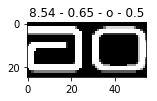

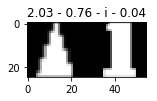

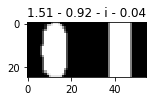

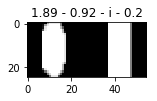

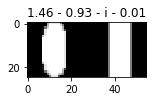

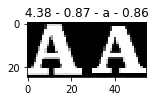

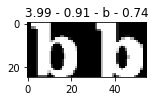

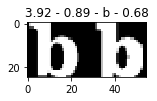

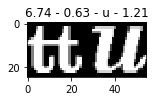

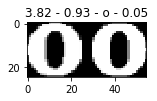

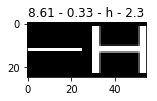

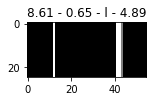

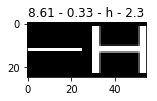

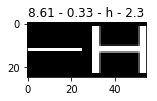

In [7]:
nfeats = small_feats.shape[2]

tm = np.array([[np.corrcoef(small_feats[:,:,j].flatten(),
                            fontmat[i,:].reshape(25,25).flatten())[0,1]
                for i in range(fontmat.shape[0])]
               for j in range(nfeats)])

scores = np.amax(tm, axis=1)
assignments = np.argmax(tm, axis=1)
pc_actual = np.array([perimetric_complexity(small_feats[:,:,s]) for s in range(nfeats)])

max_letter = fontdf['letter'].as_matrix()[assignments]
top_indices = [np.where(tm[s,:] > np.max(tm[s,:])-top_tolerance)[0] for s in range(nfeats)]
top_scores = [tm[s,:][top_indices[s]] for s in range(nfeats)]
top_letters = [fontdf['letter'].as_matrix()[top_indices[s]][np.argsort(-top_scores[s])] 
               for s in range(nfeats)]

assigned_pc = [perimetric_complexity(fontmat[assignments[s],:].reshape((25,25))) 
               for s in range(small_feats.shape[2])]
pc_diff = np.abs(pc_actual - assigned_pc)

for s in range(small_feats.shape[2]):
    plt.figure(figsize=(3,1))
    plt.title(np.round(pc_actual[s],2).astype('str') + " - " + 
              np.round(scores[s],2).astype('str') + " - " + 
              max_letter[s] + " - " + np.round(pc_diff[s],2).astype('str'))
    plt.imshow(np.hstack([small_feats[:,:,s],
                          np.zeros((25,5)),
                          fontmat[assignments[s],:].reshape((25,25))]), 
               interpolation='nearest', cmap='gray')

In [8]:
top_scores, top_letters

([array([0.61772117, 0.6494297 , 0.63081983, 0.60958996]),
  array([0.74709113, 0.72101974, 0.71214324, 0.73057305, 0.71224476,
         0.72923405, 0.71632429, 0.71192266, 0.72512407, 0.72333177,
         0.7412104 , 0.74580826, 0.73141805, 0.71585545, 0.75173836,
         0.76084687, 0.73307711, 0.71343838, 0.73277265, 0.71126008,
         0.72360458]),
  array([0.90056276, 0.87485279, 0.92265047, 0.89464232, 0.90056276]),
  array([0.90438485, 0.91601762, 0.91876445, 0.90438485]),
  array([0.90850075, 0.92522427, 0.91076866, 0.90850075]),
  array([0.82892028, 0.87400657]),
  array([0.87127733, 0.90740728]),
  array([0.86207533, 0.89415123]),
  array([0.62824237, 0.59673907, 0.61719081, 0.62232836, 0.59120289]),
  array([0.88630205, 0.89626248, 0.92572695, 0.90451642, 0.87857372,
         0.8777422 ]),
  array([0.28240876, 0.28532601, 0.32978069, 0.30961648, 0.28030877]),
  array([0.64951905]),
  array([0.28240876, 0.28532601, 0.32978069, 0.30961648, 0.28030877]),
  array([0.28240876,

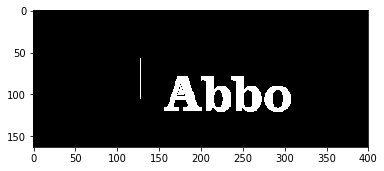

In [9]:
# Isolate the part of the image that corresponds to the characters:

allchars = np.isin(regionalized-1, np.where(is_char))

plt.imshow(allchars, interpolation='nearest', cmap='gray')

In [10]:
remaining_letters

['t', 't', '-', 'b', 's']

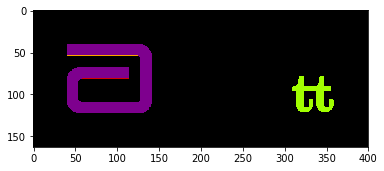

In [11]:
# Isolate the remainder, which should be the marks:

marks = np.copy(regionalized)
if np.sum(is_char) > 0:
    for j in np.nditer(np.where(is_char)[0]):
        ch = convex_hull_image(((regionalized-1)==j).astype('float'))
        border_regions, region_counts = np.unique(regionalized[np.bitwise_xor(morphology.dilation(ch, selem=disk(3)), ch)], return_counts=True)
        fill = border_regions[np.argmax(region_counts)]
        marks[ch] = fill

plt.imshow(marks, interpolation='nearest', cmap="nipy_spectral")

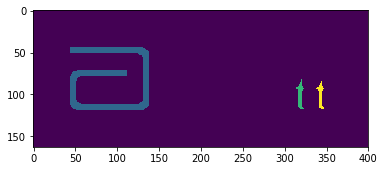

In [12]:
# Apply erosion to try to separate stuck-together characters:

eroded_labels = np.zeros_like(marks)
if np.sum(marks) > 0:
    cur_max_lab = 0
    for mr in np.unique(marks[marks>0]):
        mr_eroded_labeled = label(morphology.erosion((marks==mr).astype('bool'), selem=morphology.disk(erosion_radius)))
        mr_eroded_labeled[mr_eroded_labeled > 0] = cur_max_lab + mr_eroded_labeled[mr_eroded_labeled > 0]
        cur_max_lab = np.max(mr_eroded_labeled)
        eroded_labels += mr_eroded_labeled
        
        
plt.figure()
plt.imshow(eroded_labels, interpolation='nearest')

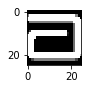

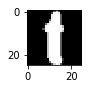

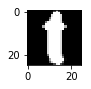

In [13]:
if np.sum(eroded_labels) > 0:
    eroded_segmentation = np.zeros((25,25,np.max(eroded_labels)))
    for lab in range(1,np.max(eroded_labels)+1):
        eroded_segmentation[:,:,lab-1] = make_small_feature(remove_segmentation_bg(
            morphology.dilation(eroded_labels==lab, selem=morphology.disk(erosion_radius))))
        plt.figure(figsize=(1,1))
        plt.imshow(eroded_segmentation[:,:,lab-1], interpolation='nearest', cmap='gray')

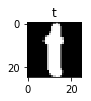

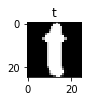

In [14]:
if np.sum(eroded_labels) > 0:
    eroded_chars, eroded_match, remaining_letters = detect_chars(eroded_segmentation, fontdf=fontdf, name=name, 
                                                                 remaining_letters=remaining_letters,
                                                                 pc_cutoff=pc_cutoff, 
                                                                 name_low_pc_score=name_low_pc_score, 
                                                                 name_high_pc_score=name_high_pc_score,
                                                                 low_pc_score=low_pc_score, 
                                                                 high_pc_score=high_pc_score, 
                                                                 i_score=i_score, 
                                                                 o_score=o_score,
                                                                 amp_score=amp_score,
                                                                 top_tolerance=top_tolerance,
                                                                 pc_diff_limit=pc_diff_limit)
    
    letters_found = fontdf['letter'][eroded_match[eroded_chars]].as_matrix()
    if letters_found.size > 0:
        l = 0
        for s in range(eroded_segmentation.shape[2]):
            if eroded_chars[s]:
                plt.figure(figsize=(1,1))
                plt.title(letters_found[l])
                plt.imshow(eroded_segmentation[:,:,s], interpolation='nearest', cmap='gray')
                l += 1

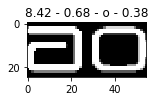

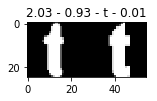

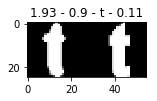

In [15]:
if np.sum(eroded_labels) > 0:
    small_feats = eroded_segmentation

    nfeats = small_feats.shape[2]

    tm = np.array([[np.corrcoef(small_feats[:,:,j].flatten(),
                                fontmat[i,:].reshape(25,25).flatten())[0,1]
                    for i in range(fontmat.shape[0])]
                   for j in range(nfeats)])

    scores = np.amax(tm, axis=1)
    assignments = np.argmax(tm, axis=1)
    pc_actual = np.array([perimetric_complexity(small_feats[:,:,s]) for s in range(nfeats)])

    max_letter = fontdf['letter'].as_matrix()[assignments]
    top_indices = [np.where(tm[s,:] > np.max(tm[s,:])-0.025)[0] for s in range(nfeats)]
    top_scores = [tm[s,:][top_indices[s]] for s in range(nfeats)]
    top_letters = [fontdf['letter'].as_matrix()[top_indices[s]][np.argsort(-top_scores[s])] for s in range(nfeats)]

    assigned_pc = [perimetric_complexity(fontmat[assignments[s],:].reshape((25,25))) 
               for s in range(small_feats.shape[2])]
    pc_diff = np.abs(pc_actual - assigned_pc)

    for s in range(small_feats.shape[2]):
        plt.figure(figsize=(3,1))
        plt.title(np.round(pc_actual[s],2).astype('str') + " - " + 
                  np.round(scores[s],2).astype('str') + " - " + 
                  max_letter[s] + " - " + np.round(pc_diff[s],2).astype('str'))
        plt.imshow(np.hstack([small_feats[:,:,s],
                              np.zeros((25,5)),
                              fontmat[assignments[s],:].reshape((25,25))]), 
                   interpolation='nearest', cmap='gray')

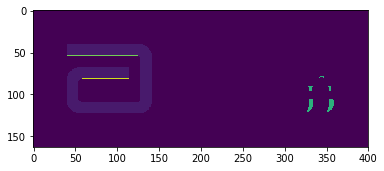

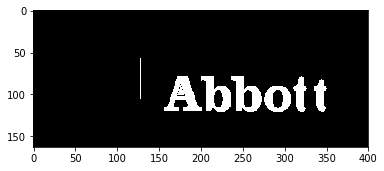

In [16]:
if np.sum(eroded_labels) > 0:
    for lab in (np.where(eroded_chars)[0]):
        ch = convex_hull_image(morphology.dilation(eroded_labels==(lab+1), selem=morphology.disk(erosion_radius+2)))
        border_regions, region_counts = np.unique(marks[np.bitwise_xor(morphology.dilation(ch, selem=disk(3)), ch)], return_counts=True)
        fill = border_regions[np.argmax(region_counts)]
        marks[ch] = fill
        allchars[morphology.dilation(eroded_labels==(lab+1), selem=morphology.disk(erosion_radius))] = 1

plt.figure()
plt.imshow(marks)
plt.figure()
plt.imshow(allchars, interpolation='nearest', cmap='gray')

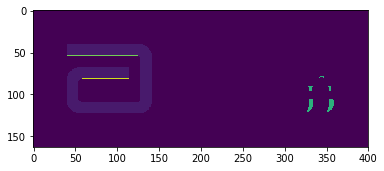

In [17]:
# Re-zero out background regions:
qbg = detect_quantized_bg(quantized)
quantized = add_quantized_padding(quantized, bgval=qbg, pad_size=20)

for mr in np.unique(marks[marks>0]):
    qmr = quantized[marks==mr]
    if np.sum(qmr==qbg)/qmr.size > qmr_cutoff:
        marks[marks==mr] = 0

plt.figure()
plt.imshow(marks)

(-0.5, 399.5, 162.5, -0.5)

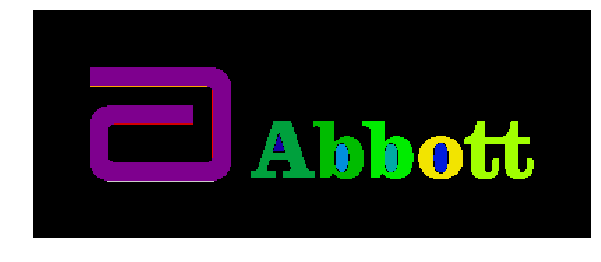

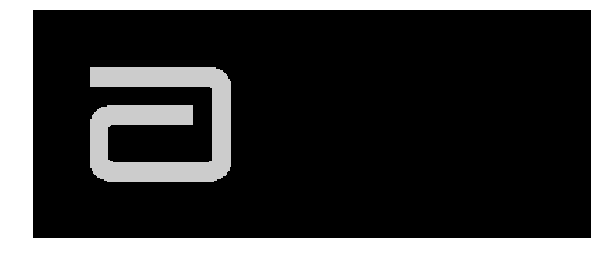

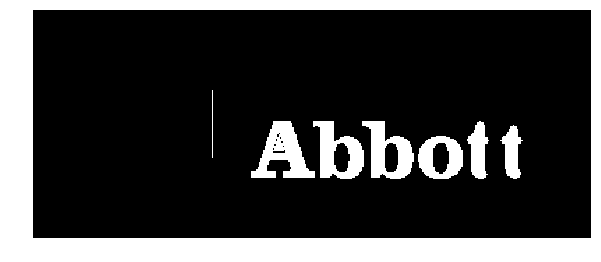

In [18]:
# Cluster the marks based on position, and eliminate very small outliers:

mark_eps = np.max((quantized.size*mark_eps_frac, 15))

mark_pix = np.transpose(np.vstack(np.where(marks > 0)))

mark_clusters = DBSCAN(algorithm='ball_tree', eps=mark_eps, min_samples=1) 
mark_clusters.fit(mark_pix)

mark_segments = np.copy(marks)
mark_segments[mark_segments > 0] = mark_clusters.labels_+1

h,w = img.shape[0:2]
img_size = h*w

mark_fracs = np.array([np.sum(mark_segments == s) / img_size for s in range(np.max(mark_segments)+1)])

big_marks = np.zeros_like(mark_segments)
index = 0
for s in range(np.max(mark_segments)+1):
    if mark_fracs[s] > mark_frac_cutoff: 
        big_marks[mark_segments==s] = index
        index += 1

        
plt.figure(figsize=(10,40))
plt.imshow(regionalized, cmap="nipy_spectral")
plt.axis('off')

plt.figure(figsize=(10,40))
plt.imshow(big_marks, cmap="nipy_spectral")
plt.axis('off')

plt.figure(figsize=(10,40))
plt.imshow(allchars, interpolation='nearest', cmap='gray')
plt.axis('off')


In [19]:
mark_eps

15.0

(-0.5, 799.5, 325.5, -0.5)

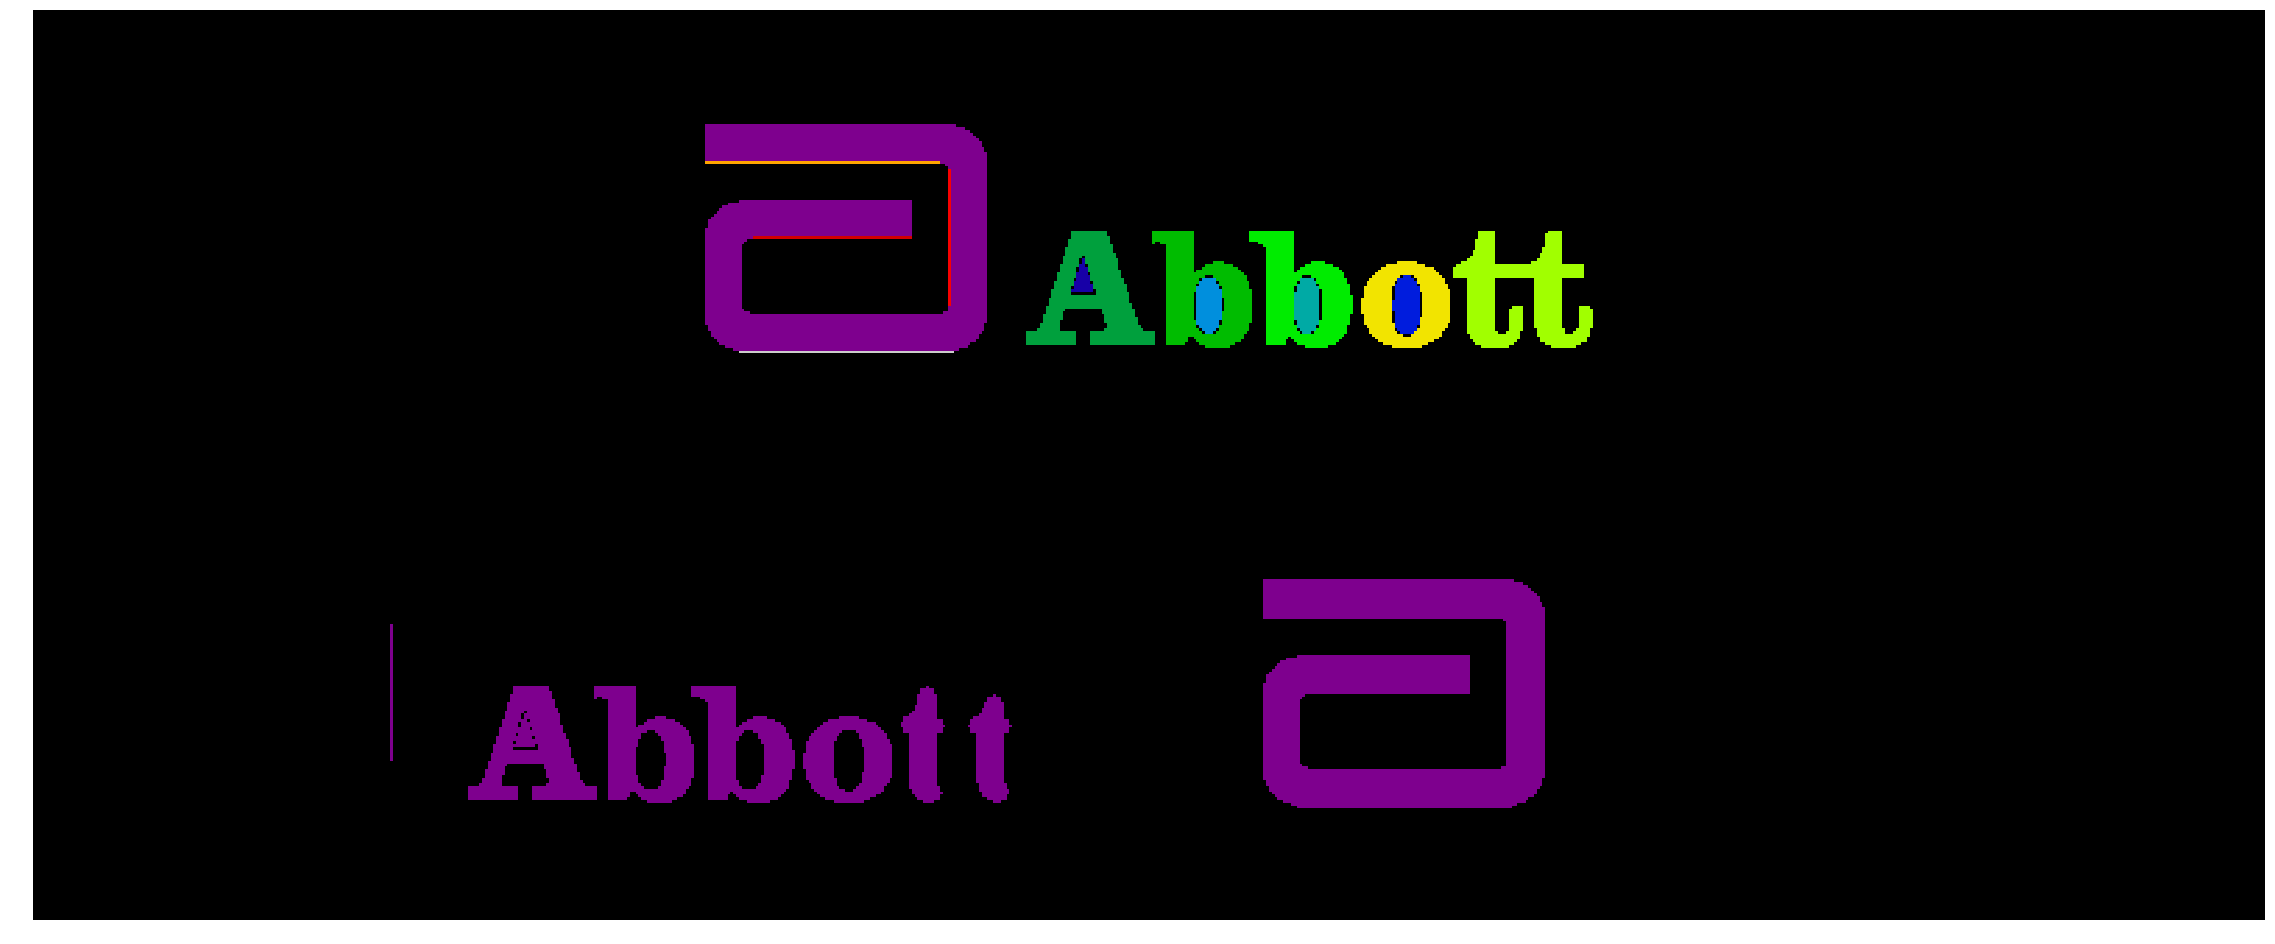

In [20]:
plt.figure(figsize=(40,50))
plt.imshow(np.vstack([np.hstack([np.zeros((allchars.shape[0],np.floor(allchars.shape[1]/2.0).astype('int'))),
                                 regionalized,
                                 np.zeros((allchars.shape[0],np.ceil(allchars.shape[1]/2.0).astype('int')))]),
                      np.hstack([allchars, big_marks])]),
          cmap="nipy_spectral")
plt.axis('off')